In [23]:
from bokeh.io.output import output_file
from traitlets.traitlets import Dict
import pandas as pd
from bokeh.models import ColumnDataSource, Select, CustomJS, DateRangeSlider, RangeSlider
from bokeh.plotting import figure, show, save
from bokeh.layouts import column, row
from bokeh.io import output_notebook
from copy import deepcopy
from datetime import date
from bokeh.io import reset_output, output_notebook
from matplotlib import pyplot as plt


reset_output()
output_notebook()

Loading BokehJS ...

In [10]:
data = pd.read_csv('Olympic_Swimming_Results_1912to2020.csv')
data2 = pd.read_csv('Olympic_Running_Results_1896to2016.csv', error_bad_lines=False)

/var/folders/hr/1895srbs4q99sk3p_pnhhnjh0000gn/T/ipykernel_86340/1552973443.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data2 = pd.read_csv('Olympic_Running_Results_1896to2016.csv', error_bad_lines=False)


In [12]:
data.head()

,Location,Year,Distance (in meters),Stroke,Relay?,Gender,Team,Athlete,Results,Rank,new_results
0,Tokyo,2020,100m,Backstroke,0,Men,ROC,Evgeny Rylov,51.98,1,51.98
1,Tokyo,2020,100m,Backstroke,0,Men,ROC,Kliment Kolesnikov,52,2,52.00
2,Tokyo,2020,100m,Backstroke,0,Men,USA,Ryan Murphy,52.19,3,52.19
3,Tokyo,2020,100m,Backstroke,0,Men,ITA,Thomas Ceccon,52.3,4,52.30
4,Tokyo,2020,100m,Backstroke,0,Men,CHN,Jiayu Xu,52.51,4,52.51


In [14]:
# Convert all Strings in "Results" to integers in seconds
def standardize(result):
    try:
        if result == "":
            return 0

        in_secs = None
        if result.count(":") > 1:
            min = result.split(':')[1]
            secs = result.split(':')[2]
            in_secs = int(min)*60 + float(secs)
        elif result.count(":") == 1:
            min = result.split(':')[0]
            secs = result.split(':')[1]
            in_secs = int(min)*60 + float(secs)
        else:
            in_secs = float(result)
    except Exception as e:
        return -1
    return in_secs

data['new_results'] = data['Results'].apply(standardize)
data2['new_results'] = data2['Result'].apply(standardize)
data.rename(columns={'Distance (in meters)': 'Distance'}, inplace=True)
data['Distance'] = data['Distance'].apply(lambda x: x.replace('x', '').replace('m', ''))
data2['Gender'] = data2['Event'].apply(lambda x: x.split(' ')[-1])
data2 = data2[data2['Event'].apply(lambda x: 'M ' in x)]
data2['Distance'] = data2['Event'].apply(lambda x: x.split(' ')[0][:-1].replace('X', '')).astype(int)
data['Distance'] = data['Distance'].astype(int)

In [15]:
avgs_swim = data.groupby(['Location', 'Year', 'Distance', 'Stroke', 'Gender']).mean()['new_results'].reset_index()
avgs_swim

,Location,Year,Distance,Stroke,Gender,new_results
0,Amsterdam,1928,100,Backstroke,Men,53.87500
1,Amsterdam,1928,100,Backstroke,Women,73.10000
2,Amsterdam,1928,100,Freestyle,Men,52.77500
3,Amsterdam,1928,100,Freestyle,Women,54.70000
4,Amsterdam,1928,200,Breaststroke,Men,130.55000
...,...,...,...,...,...,...
544,Tokyo,2020,400,Individual medley,Men,250.62000
545,Tokyo,2020,800,Freestyle,Men,465.19375
546,Tokyo,2020,800,Freestyle,Women,499.89625
547,Tokyo,2020,1500,Freestyle,Men,890.66125


In [16]:
avgs_run = data2.groupby(['Gender', 'Location', 'Year',  'Distance', 'Event']).mean()['new_results'].reset_index()
avgs_run

,Gender,Location,Year,Distance,Event,new_results
0,Men,Amsterdam,1928,100,100M Men,10.866667
1,Men,Amsterdam,1928,110,110M Hurdles Men,14.833333
2,Men,Amsterdam,1928,200,200M Men,21.866667
3,Men,Amsterdam,1928,400,400M Hurdles Men,53.533333
4,Men,Amsterdam,1928,400,400M Men,48.000000
...,...,...,...,...,...,...
440,Women,Tokyo,1964,100,100M Women,11.533333
441,Women,Tokyo,1964,200,200M Women,23.066667
442,Women,Tokyo,1964,400,400M Women,52.533333
443,Women,Tokyo,1964,800,800M Women,121.933333


In [19]:
#merging datasets

merged = pd.merge(avgs_swim, avgs_run, on=['Distance', 'Gender', 'Location', 'Year'])
merged.rename(columns={'new_results_x': 'swim_time', 'new_results_y':'run_time'}, inplace=True)

In [21]:
merged.head()

,Location,Year,Distance,Stroke,Gender,swim_time,Event,run_time
0,Amsterdam,1928,100,Backstroke,Men,53.875,100M Men,10.866667
1,Amsterdam,1928,100,Freestyle,Men,52.775,100M Men,10.866667
2,Amsterdam,1928,100,Backstroke,Women,73.100,100M Women,3.400000
3,Amsterdam,1928,100,Freestyle,Women,54.700,100M Women,3.400000
4,Amsterdam,1928,200,Breaststroke,Men,130.550,200M Men,21.866667


In [27]:
freestyle = merged[merged['Stroke'] == 'Freestyle']
freestyle = freestyle[freestyle['Event'].apply(lambda x: 'Hurdles' not in x)]

unique_events = freestyle['Event'].unique()
len(unique_events)


10

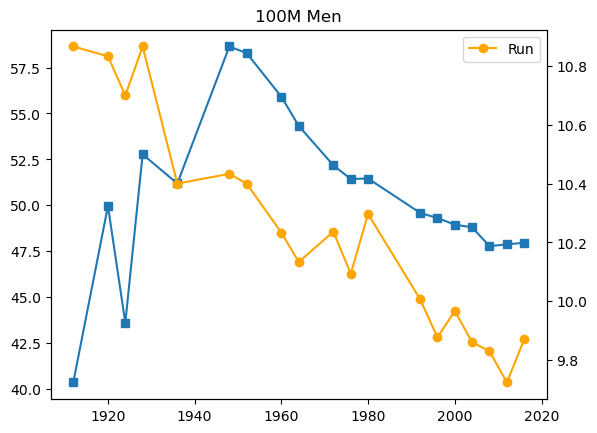

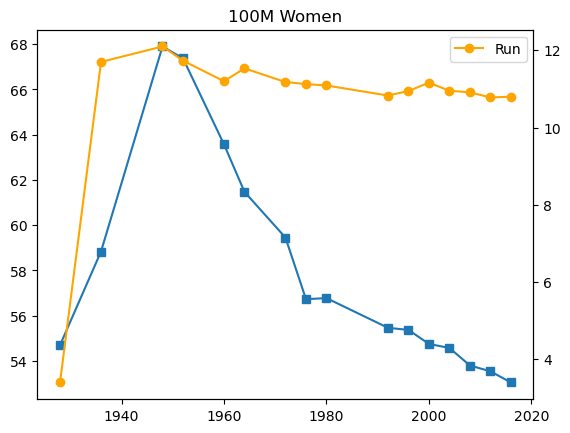

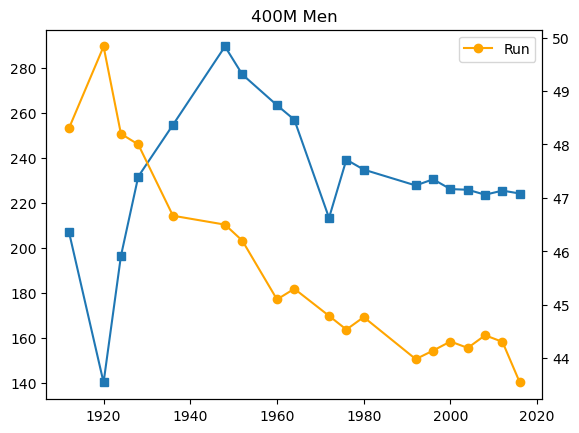

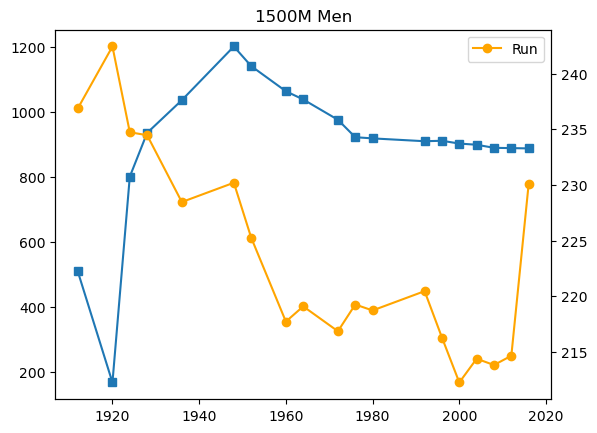

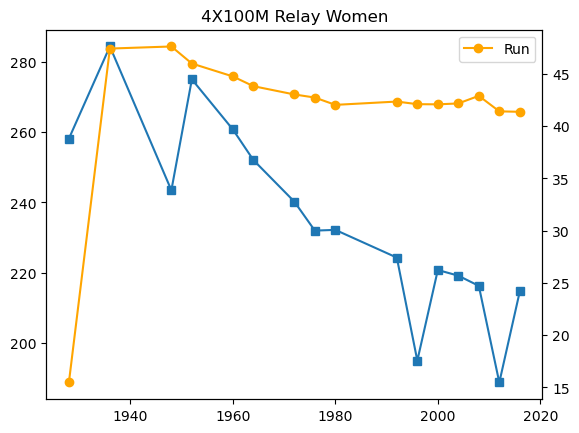

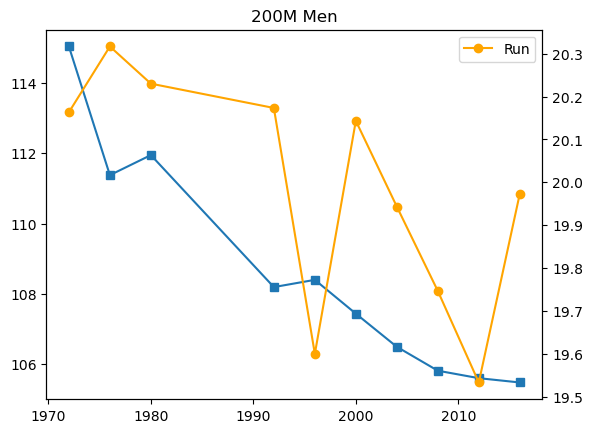

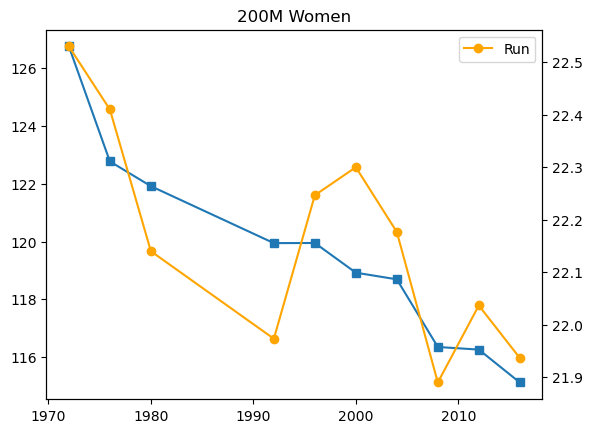

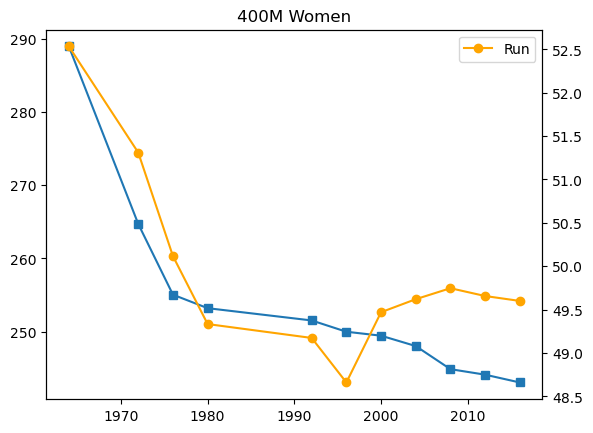

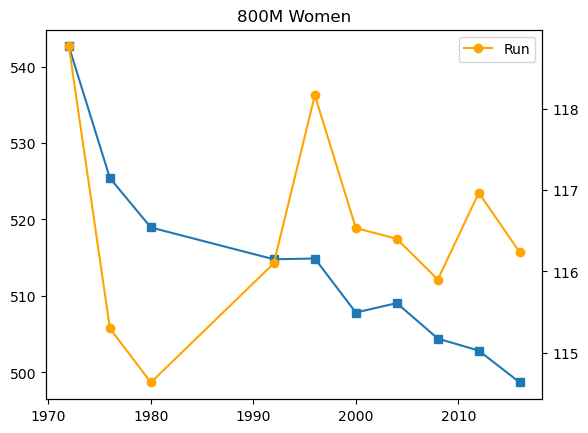

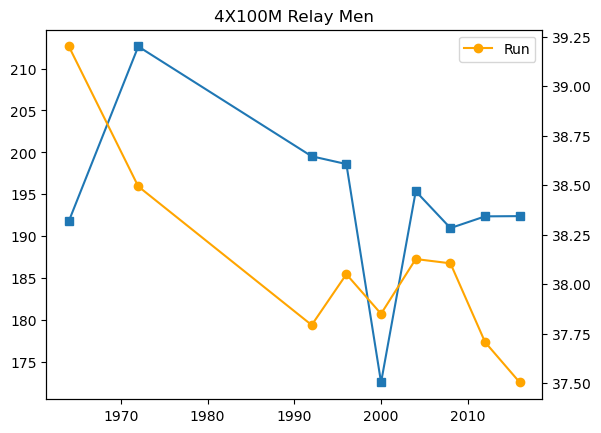

In [28]:
# fig, axs = plt.subplots(4, 3, figsize=(20, 30))

# axs = axs.flatten()

for i, event in enumerate(unique_events):
  plt.figure()
  filtered = freestyle[freestyle['Event'] == event]
  filtered = filtered.sort_values('Year')
  plt.plot(filtered['Year'], filtered['swim_time'], label='Swim', marker='s')
  plt.twinx()
  plt.plot(filtered['Year'], filtered['run_time'], label='Run', marker='o', color='orange')
  plt.title(event)
  plt.legend()
  plt.savefig(event)

In [29]:
output_file("Swim-Run-Model.html")